In [1]:
using Pkg
pkg"activate ."

In [2]:
using PerlaTonettiWaugh, LinearAlgebra, Plots, BenchmarkTools, Interpolations, QuadGK, DifferentialEquations, BlackBoxOptim, Optim, Dierckx

┌ Info: Recompiling stale cache file C:\Users\Chiyoung Ahn\.julia\compiled\v1.0\PerlaTonettiWaugh\Zi3ee.ji for PerlaTonettiWaugh [d2cacc76-b06b-11e8-362b-f18d03a16405]
└ @ Base loading.jl:1184
┌ Warning: Package PerlaTonettiWaugh does not have NLopt in its dependencies:
│ - If you have PerlaTonettiWaugh checked out for development and have
│   added NLopt as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with PerlaTonettiWaugh
└ Loading NLopt into PerlaTonettiWaugh from project dependency, future warnings for PerlaTonettiWaugh are suppressed.


Set up parameters and find the corresponding stationary solution:

In [3]:
z_min = 0.0 
z_max = 5.0
M = 1000
z_grid = range(z_min, stop = z_max, length = M) # Since we only care about the grid. 

# Define common objects. 
d_0 = 5
d_T = 2.3701
params = (ρ = 0.02, σ = 4.2508, N = 10, θ = 5.1269, γ = 1.00, κ = 0.013, ζ = 1, η = 0, Theta = 1, χ = 1/(2.1868), υ = 0.0593, μ = 0, δ = 0.053) # Baselines per Jesse. 
δ = params.δ
# solve for stationary solution at t = 0
params_0 = merge(params, (d = d_0,)) # parameters to be used at t = 0
params_T = merge(params, (d = d_T,)) # parameters to be used at t = T

stationary_sol_0 = stationary_numerical(params_0, z_grid) # solution at t = 0
stationary_sol = stationary_numerical(params_T, z_grid) # solution at t = T

Ω_0 = stationary_sol_0.Ω
Ω_T = stationary_sol.Ω
settings = (z = z_grid, tstops = nothing, Δ_E = 1e-06)

println("g = $(stationary_sol.g), z_hat = $(stationary_sol.z_hat), Ω = $(stationary_sol.Ω)")

g = 0.020419880554469364, z_hat = 1.4257125354878666, Ω = 1.0365494662606005


Define the objective function:

In [4]:
function solve_with_candidate(candidate)
    candidate = [candidate...] # if candidate is a tuple, convert it to an array
    T = candidate[end]
    
    candidate = [sort(candidate[1:(end-1)]); 0.0] # fix the point at T to be zero
    
    # construct Ω and E
    E_hat_vec_range = candidate[end] - candidate[1]
    E_hat_vec_scaled = (candidate .- candidate[1]) ./ E_hat_vec_range .- 1.0 
    ts = range(0.0, stop=T, length=length(candidate))
    E_hat_interpolation = CubicSplineInterpolation(ts, E_hat_vec_scaled) # might worth trying cubic spline
    E_hat(t) = E_hat_interpolation(t)

    M = log(Ω_T/Ω_0) / quadgk(E_hat, 0, T)[1]
    Ω_derivative(Ω,p,t) = M*E_hat(t)*Ω
    Ω_solution = try DifferentialEquations.solve(ODEProblem(Ω_derivative,Ω_0,(0.0, T)), reltol = 1e-15) catch; return Inf end
    Ω(t::Float64) = t <= T ? Ω_solution(t) : Ω_solution(T)
    E(t::Float64) = M*E_hat(t) + δ

    # solve the dynamics and get the resulting entry_residual vector; if solution is not valid, return Inf
    return solve_dynamics(params_T, stationary_sol, settings, T, Ω, E; detailed_solution = true)
end

function evaluate_candidate(candidate)
    candidate = [candidate...] # if candidate is a tuple, convert it to an array
    T = candidate[end]
    candidate = [sort(candidate[1:(end-1)]); 0.0] # fix the point at T to be zero
    
    # construct Ω and E
    E_hat_vec_range = candidate[end] - candidate[1]
    E_hat_vec_scaled = (candidate .- candidate[1]) ./ E_hat_vec_range .- 1.0 
    ts = range(0.0, stop=T, length=length(candidate))
    E_hat_interpolation = Spline1D(ts, E_hat_vec_scaled; k = 3) # cubic spline
    
    M = log(Ω_T/Ω_0) / integrate(E_hat_interpolation, 0, T)
    Ω_derivative(Ω,p,t) = M*E_hat_interpolation(t)*Ω
    Ω_solution = try DifferentialEquations.solve(ODEProblem(Ω_derivative,Ω_0,(0.0, T)), reltol = 1e-15) catch; return Inf end
    Ω = t -> t <= T ? Ω_solution(t) : Ω_solution(T)
    E = t -> M*E_hat_interpolation(t) + δ

    # solve the dynamics and get the resulting entry_residual vector; if solution is not valid, return Inf
    solved = try solve_dynamics(params_T, stationary_sol, settings, T, Ω, E; detailed_solution = false).results catch; return Inf end
    
    t = solved.t
    entry_residual = solved.entry_residual

    # interpolate on returned entry_residual
    entry_residual_interpolated = LinearInterpolation(t, entry_residual)

    # evaluate entry_residual on entry_residual_nodes, return the norm
    entry_residuals_nodes = range(0, stop = T, length = ENTRY_RESIDUALS_NODES_COUNT + 2)
    
    entry_residuals_vector = entry_residual_interpolated.(entry_residuals_nodes[2:(end-1)])
    
    return (sqrt(sum(entry_residuals_vector .* WEIGHTS .* entry_residuals_vector)))
end

evaluate_candidate (generic function with 1 method)

Setup for optimizer:

In [5]:
ENTRY_RESIDUALS_NODES_COUNT = 15
E_NODE_COUNT = 15
MAX_TIME = 50000
SOLUTION = [-0.999796577020432; -0.8036317953452055; -0.645518803247465; -0.49798592837781547; -0.3129924179644726; -0.2924929980811199; -0.19484667032438624; -0.10940512894596714; -0.09952048306670645; -0.09391117400750042; -0.04912000885073606; -0.03274479455962143; -0.016461404893110952; -0.011579533358115129; 34.61456648920588]

15-element Array{Float64,1}:
 -0.999796577020432   
 -0.8036317953452055  
 -0.645518803247465   
 -0.49798592837781547 
 -0.3129924179644726  
 -0.2924929980811199  
 -0.19484667032438624 
 -0.10940512894596714 
 -0.09952048306670645 
 -0.09391117400750042 
 -0.04912000885073606 
 -0.03274479455962143 
 -0.016461404893110952
 -0.011579533358115129
 34.61456648920588    

Find optimal `Ω`:

In [6]:
# WEIGHTS = [2; fill(1.5, 3); fill(1, ENTRY_RESIDUALS_NODES_COUNT-4)] # reducing residuals in the beginning helps overall behav.
# result2 = optimize(evaluate_candidate, SOLUTION, BFGS(), Optim.Options(time_limit = MAX_TIME, show_trace = true))
# SOLUTION = result.minimizer

Find the corresponding solution

In [7]:
# [-0.999796577020432; -0.8036317953452055; -0.645518803247465; -0.49798592837781547; -0.3129924179644726; -0.2924929980811199; -0.19484667032438624; -0.10940512894596714; -0.09952048306670645; -0.09391117400750042; -0.04912000885073606; -0.03274479455962143; -0.016461404893110952; -0.011579533358115129; 34.61456648920588]
# gives good solution.
solved = solve_with_candidate(SOLUTION)

v_t0 = solved.sol.u[1][1:M]
v0 = solved.results[:v_0]
# save v0 and v_hat_t0
v_hat_t0 = map(z -> exp((params.σ-1)*z), z_grid) .* v_t0;

solved = solved.results

,t,g,z_hat,Ω,E,v_0,L_tilde,entry_residual,λ_ii,c,S,z_bar,π_min,log_M,U
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,0.0152175,1.55327,1.62357,0.00320894,1.18798,0.0828957,0.00117904,0.807549,1.26659,0.0318032,5.49416,0.0513484,0.0,77.239
2,0.647105,0.0153796,1.5438,1.57345,0.00586005,1.18732,0.091379,0.000516488,0.80576,1.24517,0.0326342,5.33636,0.0523778,0.0098998,77.6279
3,3.89236,0.0167575,1.50531,1.37782,0.0177691,1.18702,0.128038,0.000219517,0.798238,1.15606,0.0396986,4.71692,0.0568655,0.0620465,79.6511
4,7.73085,0.0182047,1.47237,1.22941,0.029457,1.18776,0.156913,0.000960854,0.791471,1.08664,0.047118,4.24484,0.0610972,0.129148,82.1169
5,11.5693,0.0190131,1.45443,1.15047,0.0382696,1.18732,0.174978,0.000520138,0.787649,1.0458,0.0512626,3.99154,0.0635822,0.200578,84.5326
6,15.8343,0.0195598,1.44032,1.09316,0.0454485,1.18694,0.187447,0.00014451,0.784574,1.01698,0.0540656,3.80757,0.0656468,0.282834,87.0258
7,20.7938,0.0201959,1.43207,1.06423,0.0479438,1.19019,0.192338,0.00339492,0.782746,1.00432,0.0573267,3.71547,0.0668691,0.381418,89.5077
8,25.7532,0.0204084,1.42738,1.04495,0.0510412,1.18889,0.197398,0.00209107,0.781698,0.993436,0.0584159,3.65303,0.0675859,0.482105,91.3942
9,30.1839,0.0204557,1.426,1.0387,0.0522696,1.18794,0.199359,0.00114065,0.781388,0.989479,0.0586589,3.63265,0.0677991,0.572633,92.4651


## Plots for Ω and `entry_residuals`

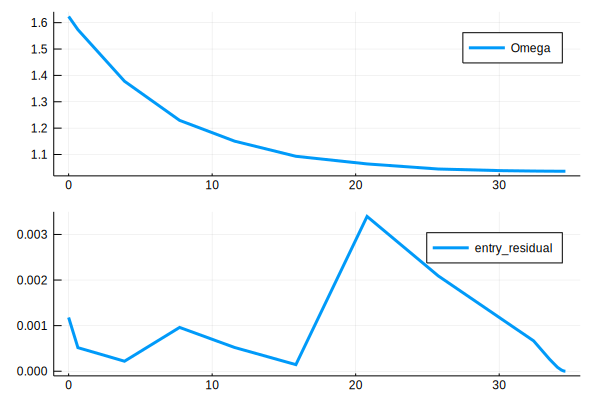

In [8]:
plot_Ω = plot(solved.t, solved.Ω, label = "Omega", lw = 3)
plot_residual = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot_Ω, plot_residual, layout = (2,1))

## Primary Plots

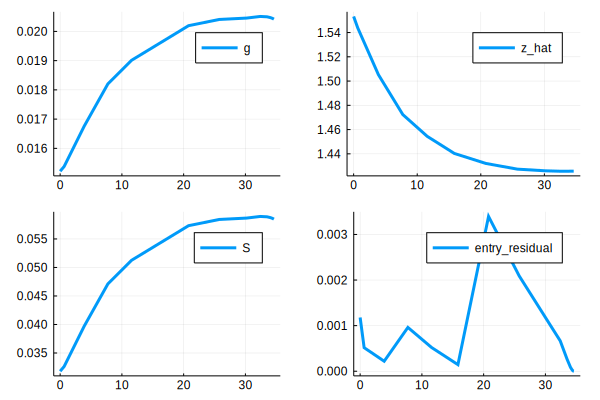

In [9]:
plot1 = plot(solved.t, solved.g, label = "g", lw = 3)
plot2 = plot(solved.t, solved.z_hat, label = "z_hat", lw = 3)
plot3 = plot(solved.t, solved.S, label = "S", lw = 3)
plot4 = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot1, plot2, plot3, plot4, layout=(2,2))

## Static Equations

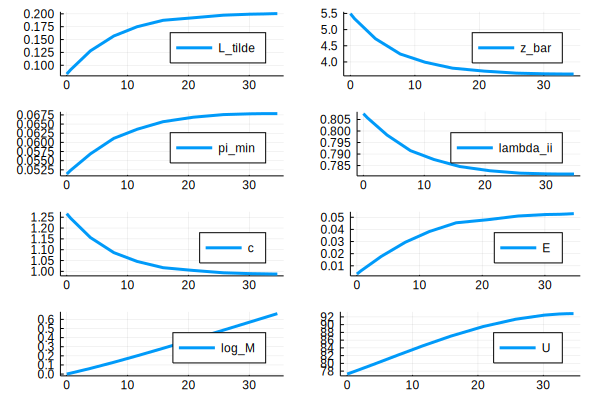

In [10]:
plot1 = plot(solved.t, solved.L_tilde, label = "L_tilde", lw = 3)
plot2 = plot(solved.t, solved.z_bar, label = "z_bar", lw = 3)
plot3 = plot(solved.t, solved.π_min, label = "pi_min", lw = 3)
plot4 = plot(solved.t, solved.λ_ii, label = "lambda_ii", lw = 3)
plot5 = plot(solved.t, solved.c, label = "c", lw = 3)
plot6 = plot(solved.t, solved.E, label = "E", lw = 3)
plot7 = plot(solved.t, solved.log_M, label = "log_M", lw = 3)
plot8 = plot(solved.t, solved.U, label = "U", lw = 3)
plot9 = plot(z_grid, v_hat_t0, label = "v_hat at t = 0", lw = 3)
plot(plot1, plot2, plot3, plot4, plot5, plot6, plot7, plot8, layout=(4,2))

In [11]:
# Can examine the returned data with the Voyager and/or Vegalite
using DataVoyager, VegaLite
solved |> Voyager()
#solved |> @vlplot(:line, x = :t, y = :g, width=400, height=400)

ErrorException: Path contained unexpected character